In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/export.pkl
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/f481f76a6b75.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/abdb365cacbc.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/33ffddea8c6e.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/278aa860dffd.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/d66b6f333dc7.png
/kaggle/i

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from glob import glob
import albumentations as A
from collections import Counter
import warnings
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
warnings.filterwarnings('ignore')
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
class Config:
    IMG_SIZE = 224
    BATCH_SIZE = 16
    EPOCHS = 190
    LEARNING_RATE = 0.001
    PATIENCE = 25
    MIN_LR = 1e-8
    WEIGHT_DECAY = 1e-4
    CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
    NUM_CLASSES = len(CLASS_NAMES)
    DATA_PATH = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
    MIN_SAMPLES_PER_CLASS = 800
    MAX_SAMPLES_PER_CLASS = 2000
class CustomAdamW(tf.keras.optimizers.Adam): #自訂優化器
    def __init__(self, weight_decay=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.weight_decay = weight_decay

    def _resource_apply_dense(self, grad, var, apply_state=None):
        if self.weight_decay:
            grad += self.weight_decay * var
        return super()._resource_apply_dense(grad, var, apply_state)
class AdvancedAugmentation: #影像增強技術
    @staticmethod
    def get_train_augmentation():
        return A.Compose([
            A.HorizontalFlip(p=0.4),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=15, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.CLAHE(clip_limit=2.0, p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    @staticmethod
    def get_val_augmentation():
        return A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
class EnhancedDataGenerator(tf.keras.utils.Sequence): #資料生成器
    def __init__(self, image_paths, labels, batch_size, img_size, augmentation=None, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()
        self.image_cache = {path: self._load_image(path) for path in image_paths}

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        X, y = self._generate_data(batch_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_image(self, path):
        image = cv2.imread(path)
        if image is None:
            return np.zeros((self.img_size, self.img_size, 3), dtype=np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return cv2.resize(image, (self.img_size, self.img_size))

    def _generate_data(self, batch_paths, batch_labels):
        X = np.empty((len(batch_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(batch_paths), Config.NUM_CLASSES), dtype=np.float32)
        for i, (path, label) in enumerate(zip(batch_paths, batch_labels)):
            image = self.image_cache[path].copy()
            if self.augmentation:
                augmented = self.augmentation(image=image)
                image = augmented['image']
            X[i] = image
            y[i] = tf.keras.utils.to_categorical(label, Config.NUM_CLASSES)
        return X, y

2025-07-17 14:24:45.385059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752762285.572673      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752762285.630171      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import matplotlib.pyplot as plt



def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss 折線圖
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy 折線圖
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# === Dataset Loading ===
def load_dataset(data_path):
    image_paths, labels = [], []
    for idx, cls in enumerate(Config.CLASS_NAMES):
        cls_path = os.path.join(data_path, cls)
        if os.path.exists(cls_path):
            images = glob(os.path.join(cls_path, '*'))
            image_paths.extend(images)
            labels.extend([idx] * len(images))

    image_paths, labels = np.array(image_paths), np.array(labels)
    from collections import defaultdict
    class_counts = defaultdict(list)
    for i, lbl in enumerate(labels):
        class_counts[lbl].append(image_paths[i])

    balanced_paths, balanced_labels = [], []
    for lbl, paths in class_counts.items():
        paths = np.array(paths)
        count = len(paths)
        target = min(max(Config.MIN_SAMPLES_PER_CLASS, count), Config.MAX_SAMPLES_PER_CLASS)
        if count < target:
            extra = np.random.choice(paths, size=(target - count), replace=True)
            paths = np.concatenate([paths, extra])
        else:
            paths = np.random.choice(paths, size=target, replace=False)
        balanced_paths.extend(paths)
        balanced_labels.extend([lbl] * target)

    balanced_paths, balanced_labels = np.array(balanced_paths), np.array(balanced_labels)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42) #測試集 (15%)
    for remain_idx, test_idx in sss1.split(balanced_paths, balanced_labels):
        remain_paths, test_paths = balanced_paths[remain_idx], balanced_paths[test_idx]
        remain_labels, test_labels = balanced_labels[remain_idx], balanced_labels[test_idx]

        val_ratio = 0.15 / 0.85  # ≈ 0.1765
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
        for train_idx, val_idx in sss2.split(remain_paths, remain_labels):
            train_paths, val_paths = remain_paths[train_idx], remain_paths[val_idx]
            train_labels, val_labels = remain_labels[train_idx], remain_labels[val_idx]
             # 印出各資料集類別數量檢查
    from collections import Counter
    print("Train label distribution:", Counter(train_labels))
    print("Val label distribution:", Counter(val_labels))
    print("Test label distribution:", Counter(test_labels))

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

In [ ]:
def quick_balance_report(data_path):
    """快速查看資料平衡結果"""
    print("資料平衡快速報告")
    print("=" * 50)

    # 載入並統計原始資料
    for idx, cls in enumerate(Config.CLASS_NAMES):
        cls_path = os.path.join(data_path, cls)
        if os.path.exists(cls_path):
            images = glob(os.path.join(cls_path, '*'))
            count = len(images)
            target = min(max(Config.MIN_SAMPLES_PER_CLASS, count), Config.MAX_SAMPLES_PER_CLASS)

            if count < target:
                status = f"➕ 複製到 {target:,}"
            elif count > target:
                status = f"➖ 減少到 {target:,}"
            else:
                status = "保持不變"

            print(f"{cls:<15}: {count:>6,} → {status}")

In [ ]:
# 只想快速看看平衡效果
quick_balance_report(Config.DATA_PATH)

資料平衡快速報告
No_DR          :  1,805 → 保持不變
Mild           :    370 → ➕ 複製到 800
Moderate       :    999 → 保持不變
Severe         :    193 → ➕ 複製到 800
Proliferate_DR :    295 → ➕ 複製到 800


In [ ]:
# === Model Definition ===
def create_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(Config.WEIGHT_DECAY))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    def residual_block(x, filters, strides=1): #殘差區塊
        shortcut = x
        x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same', kernel_regularizer=tf.keras.regularizers.l2(Config.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(Config.WEIGHT_DECAY))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        if strides > 1 or shortcut.shape[-1] != filters:
            shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, kernel_regularizer=tf.keras.regularizers.l2(Config.WEIGHT_DECAY))(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)
        x = tf.keras.layers.add([x, shortcut])
        x = tf.keras.layers.ReLU()(x)
        return x

    for f, s in [(64,1), (64,1), (128,2), (128,1), (256,2), (256,1), (512,2), (512,1)]:
        x = residual_block(x, f, s)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(Config.WEIGHT_DECAY))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.SpatialDropout2D(0.3)(tf.expand_dims(tf.expand_dims(x, 1), 1))
    #x = tf.squeeze(x, [1, 2])
    x = tf.keras.layers.Reshape((1, 1, 512))(x)
    x = tf.keras.layers.SpatialDropout2D(0.3)(x)
    x = tf.keras.layers.Flatten()(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# === Training ===
def main():
    (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = load_dataset(Config.DATA_PATH)

    # 建立資料增強器
    train_aug = AdvancedAugmentation.get_train_augmentation()
    val_aug = AdvancedAugmentation.get_val_augmentation()

    # 建立資料產生器
    train_gen = EnhancedDataGenerator(train_paths, train_labels, Config.BATCH_SIZE, Config.IMG_SIZE, train_aug, shuffle=True)
    val_gen = EnhancedDataGenerator(val_paths, val_labels, Config.BATCH_SIZE, Config.IMG_SIZE, val_aug, shuffle=False)
    test_gen = EnhancedDataGenerator(test_paths, test_labels, Config.BATCH_SIZE, Config.IMG_SIZE, val_aug, shuffle=False)

    # 建立模型
    model = create_model((Config.IMG_SIZE, Config.IMG_SIZE, 3), Config.NUM_CLASSES)
    model.compile(
        optimizer=CustomAdamW(learning_rate=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        #metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2), tf.keras.metrics.AUC(name='auc')]
        metrics=['accuracy']
    )

    # 訓練模型
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=Config.MIN_LR),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=Config.PATIENCE, restore_best_weights=True)
    ]

    history = model.fit(train_gen, validation_data=val_gen, epochs=Config.EPOCHS, callbacks=callbacks, verbose=1)
    return model, history

Train label distribution: Counter({0: 1263, 2: 699, 3: 560, 4: 560, 1: 560})
Val label distribution: Counter({0: 271, 2: 150, 3: 120, 1: 120, 4: 120})
Test label distribution: Counter({0: 271, 2: 150, 4: 120, 1: 120, 3: 120})
Epoch 1/190


I0000 00:00:1752762816.972339      95 service.cc:148] XLA service 0x7d9920003e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752762816.973222      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752762819.042948      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/228 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.2465 - loss: 3.2983   

I0000 00:00:1752762828.900949      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


228/228 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.3990 - loss: 2.0891 - val_accuracy: 0.3854 - val_loss: 1.9944 - learning_rate: 0.0010
Epoch 2/190
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4509 - loss: 1.8556 - val_accuracy: 0.4955 - val_loss: 1.8873 - learning_rate: 0.0010
Epoch 3/190
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4874 - loss: 1.7462 - val_accuracy: 0.4878 - val_loss: 1.6134 - learning_rate: 0.0010
Epoch 4/190
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4798 - loss: 1.6887 - val_accuracy: 0.4738 - val_loss: 1.6131 - learning_rate: 0.0010
Epoch 5/190
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5028 - loss: 1.6067 - val_accuracy: 0.5173 - val_loss: 1.5705 - learning_rate: 0.0010
Epoch 6/190
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.5153 - loss: 1.5558 - val_accuracy: 0.5006 - val_loss: 1.4779 - learning_rate: 0.0010
Epoch 7/190
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5535 - loss:

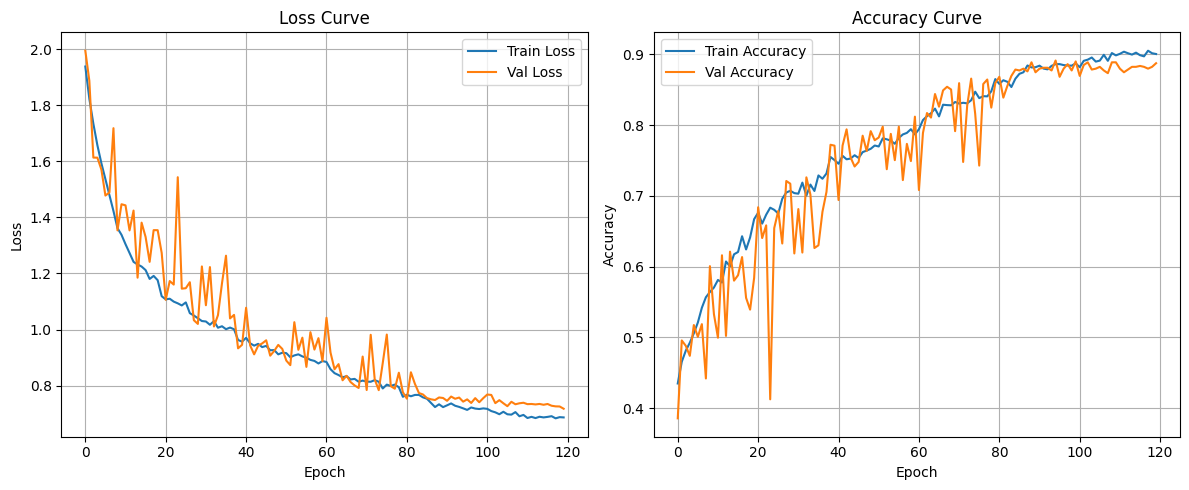

In [ ]:
model, history = main()
plot_training_history(history)

Train label distribution: Counter({0: 1263, 2: 699, 3: 560, 4: 560, 1: 560})
Val label distribution: Counter({0: 271, 2: 150, 3: 120, 1: 120, 4: 120})
Test label distribution: Counter({0: 271, 2: 150, 4: 120, 1: 120, 3: 120})
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

 Classification Report (on Test Set):

                precision    recall  f1-score   support

         No_DR       0.97      0.99      0.98       271
          Mild       0.87      0.82      0.85       120
      Moderate       0.83      0.90      0.87       150
        Severe       0.93      0.93      0.93       120
Proliferate_DR       0.89      0.82      0.86       120

      accuracy                           0.91       781
     macro avg       0.90      0.89      0.90       781
  weighted avg       0.91      0.91      0.91       781



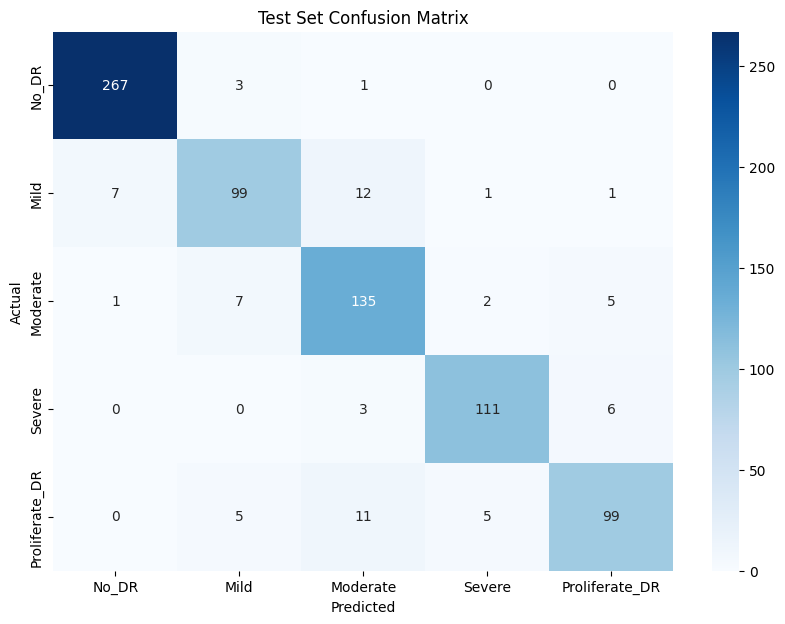

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 取得 test set
_, _, (test_paths, test_labels) = load_dataset(Config.DATA_PATH)

# 使用 validation 的增強方式（測試集不可用隨機變化）
test_aug = AdvancedAugmentation.get_val_augmentation()

# 建立 test generator
test_gen = EnhancedDataGenerator(test_paths, test_labels, Config.BATCH_SIZE, Config.IMG_SIZE, test_aug, shuffle=False)

# 預測機率
y_probs = model.predict(test_gen, verbose=1)

# 轉為類別預測
y_pred = np.argmax(y_probs, axis=1)
y_true = test_labels
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n Classification Report (on Test Set):\n")
print(classification_report(y_true, y_pred, target_names=Config.CLASS_NAMES))

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=Config.CLASS_NAMES,
            yticklabels=Config.CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()